<a href="https://colab.research.google.com/github/julialromero/Collaborative-Problem-Solving/blob/main/learning_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
from keras import layers, Input, Model, optimizers

# Scratchwork

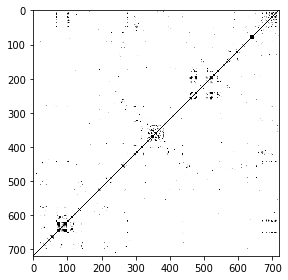

In [3]:
from skimage import io
imag = io.imread('drive/MyDrive/data/RAW/1010-ExpBlock1_RAW.png', as_gray=True)
io.imshow(imag)

In [6]:
for filename in os.listdir('drive/MyDrive/data/RAW/')[0:15]:
  imag = io.imread('drive/MyDrive/data/RAW/' + filename, as_gray=True)
  print(imag.shape)

(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)
(719, 719)


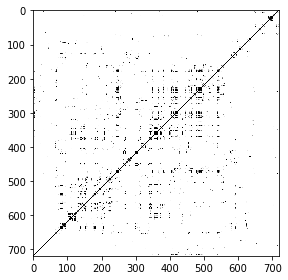

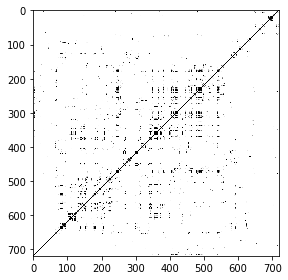

In [20]:
imgsize = (int(719/2), int(719/2)) 
imag = io.imread('drive/MyDrive/data/RAW/1020-ExpBlock1_RAW.png', as_gray=True)
plt.figure()
io.imshow(imag)
x = image.img_to_array(imag)

#x = tf.keras.preprocessing.image.smart_resize(x, imgsize)
x = np.array(x)
plt.figure()
io.imshow(x.squeeze())
#n = preprocess_input(x)    # preprocess input for Inception v3

### (760, 598, 4)

# Helper Functions

---NOTE---
Resizing the image changes the RP so for now keep it the same size.

In [38]:
# read, preprocess, and scale images to uniform dimension
imgsize = (int(719/2), int(719/2)) 

def extract_image(image_path):
    imag = io.imread(image_path, as_gray=True)
    x = image.img_to_array(imag)

    x = tf.image.resize(x, imgsize) # TODO: try interpolation = "nearest" instead of default "bilinear"
    
    #n = preprocess_input(x)
    return x

In [22]:
def accuracy(predicted, observed):
    if(len(predicted) != len(observed)):
        print("Error - length of input series is not equal.")
        return np.nan
    
    correct = 0
    for pred, obs in zip(predicted, observed):
        if pred == obs:
            correct += 1
    acc = correct / len(predicted)
    return acc

In [23]:
# Use InceptionV3 model for feature extraction
base_model = tf.keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(None, None, 3),
    pooling='max',
)

# First Model - Classification.
Output layer has 16 nodes with softmax activation.
y labels are one hot encoded, so the neural network learns to get as close to one hot encoded vectors during training. For final accuracy, the outputs are reverse transfomed to labels based on which node has the highest value.

In [61]:
# Garcia-Ceja paper feeds CNN images with dims 100 x 100 x 4 (width x height x channels)
# Labels are one hot encoded

inputs = Input(shape=(imgsize[0], imgsize[1], 1))
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(512, activation="relu")(x) 
x = layers.Dropout(0.50)(x)
x = layers.Flatten()(x)
out = layers.Dense(16, activation="softmax")(x) 


cc = tf.keras.losses.CategoricalCrossentropy()
adam = keras.optimizers.Adam(learning_rate=0.00001)
model = Model(inputs=inputs, outputs=out)
model.compile(
  optimizer = adam,
  loss= cc, #"mse", #tf.keras.losses.MeanSquaredError(),  
  metrics=['accuracy'],
)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 359, 359, 1)]     0         
                                                                 
 conv2d_204 (Conv2D)         (None, 357, 357, 16)      160       
                                                                 
 conv2d_205 (Conv2D)         (None, 355, 355, 16)      2320      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 177, 177, 16)     0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 177, 177, 16)      0         
                                                                 
 conv2d_206 (Conv2D)         (None, 175, 175, 32)      4640      
                                                           

## Load and preprocess data

In [34]:
outcome_df = pd.read_csv("drive/MyDrive/data/team_block_outcomes.csv")

In [36]:
def extract_score(filename, outcome_df, score_col="task_score"):
    #  match this file's id/block with task score and return
    groupid, splitname = filename.split("-")
    block = splitname.split("_")[0]
    row = outcome_df.loc[(outcome_df.GROUPID == int(groupid)) & (outcome_df.block == block)]
    if(row.shape[0] != 1):
        print(f"Error -- Number of task scores recorded is not 1 for block {block} and groupid {groupid}.")
        return np.nan
    score = row[score_col].values[0]
    return score

In [39]:
# read data to np arrays
recurrence_plot_list = []
labels = []
for filename in os.listdir('drive/MyDrive/data/RAW/'):
    # preprocess image
    t = extract_image('drive/MyDrive/data/RAW/' + filename)
    
    # get task score
    lab = extract_score(filename, outcome_df, score_col="task_score")
    
    recurrence_plot_list.append(t)
    labels.append(lab)

recurrence_plot_list = np.array(recurrence_plot_list)
labels = np.array(labels)

print(f"Number of samples: {recurrence_plot_list.shape[0]}")

Number of samples: 271


In [40]:
if (recurrence_plot_list.shape[0] == len(np.unique(recurrence_plot_list, axis=0))):
  print("No duplicate samples.")
else:
  print("WARNING - duplicate samples.")

No duplicate samples.


In [58]:
import sklearn
from sklearn.model_selection import train_test_split

# Split into train/test/val set
# Roughly val - 15%, test - 15%, train - 70%
X_train, X_test, y_train, y_test = train_test_split(recurrence_plot_list, labels, train_size=0.88)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.78)

In [59]:
from sklearn.preprocessing import OneHotEncoder

# one hot encode
enc = OneHotEncoder()

# possible labels are 0 through 15 so lets create fake data to fit encoder
encode_data = np.array([i for i in range(0, 16)]).reshape(-1, 1)
enc.fit(encode_data)

# now transform y train/validation data
y_train_enc = enc.transform(y_train.reshape(-1, 1))
y_val_enc = enc.transform(y_val.reshape(-1, 1))
y_train_enc = y_train_enc.toarray()
y_val_enc = y_val_enc.toarray()


In [62]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', patience=15)
mcp_save = ModelCheckpoint('drive/MyDrive/data/results/.categorical_best_weights.hdf5', save_best_only=True, monitor='val_loss', mode='min')

info1 = model.fit(x=X_train, y=y_train_enc, epochs=70, verbose=True, validation_data=(X_val, y_val_enc), callbacks=[mcp_save, es])

Epoch 1/70
6/6 [==============================] - 15s 3s/step - loss: 2.5051 - accuracy: 0.1189 - val_loss: 2.4984 - val_accuracy: 0.1509
Epoch 2/70
6/6 [==============================] - 2s 262ms/step - loss: 2.4626 - accuracy: 0.1784 - val_loss: 2.5069 - val_accuracy: 0.1321
Epoch 3/70
6/6 [==============================] - 2s 262ms/step - loss: 2.4041 - accuracy: 0.1459 - val_loss: 2.5252 - val_accuracy: 0.2075
Epoch 4/70
6/6 [==============================] - 2s 264ms/step - loss: 2.4027 - accuracy: 0.1297 - val_loss: 2.5383 - val_accuracy: 0.1509
Epoch 5/70
6/6 [==============================] - 2s 264ms/step - loss: 2.3843 - accuracy: 0.1892 - val_loss: 2.5203 - val_accuracy: 0.1509
Epoch 6/70
6/6 [==============================] - 2s 267ms/step - loss: 2.3665 - accuracy: 0.1892 - val_loss: 2.4995 - val_accuracy: 0.1132
Epoch 7/70
6/6 [==============================] - 2s 270ms/step - loss: 2.3742 - accuracy: 0.1838 - val_loss: 2.5150 - val_accuracy: 0.1132
Epoch 8/70
6/6 [======

Text(0.5, 1.0, 'Loss for Softmax, 16 nodes in output')

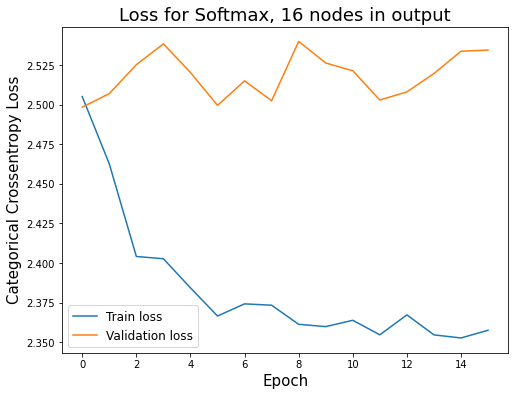

In [63]:
epochs = [i for i in range(len(info1.history['accuracy']))]
plt.figure(figsize=(8,6))
plt.plot(epochs, info1.history['loss'], label="Train loss")
plt.plot(epochs, info1.history['val_loss'], label="Validation loss")
plt.legend(fontsize=12)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("Categorical Crossentropy Loss", fontsize=15)
plt.title("Loss for Softmax, 16 nodes in output", fontsize=18)
#plt.savefig('drive/MyDrive/data/results/Softmax_categorical')

In [64]:
model.load_weights(filepath = 'drive/MyDrive/data/results/.categorical_best_weights.hdf5')

In [65]:
# now calculate the actual accuracy
test_predictions = model.predict(X_test)
train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)

In [66]:
final_pred = enc.inverse_transform(test_predictions).squeeze()
final_train_pred = enc.inverse_transform(train_predictions).squeeze()
final_val_pred = enc.inverse_transform(val_predictions).squeeze()

In [67]:
test_acc = accuracy(final_pred, y_test)
train_acc = accuracy(final_train_pred, y_train)
val_acc = accuracy(final_val_pred, y_val)
print("Classification with softmax")
print("----Results----")
print(f"Size of train set: {y_train.shape[0]}")
print(f"Train acc: {train_acc}")
print(f"----\nSize of validation set: {y_val.shape[0]}")
print(f"Validation acc: {val_acc}")
print(f"----\nSize of test set: {y_test.shape[0]}")
print(f"Test acc: {test_acc}")

Classification with softmax
----Results----
Size of train set: 185
Train acc: 0.1891891891891892
----
Size of validation set: 53
Validation acc: 0.1509433962264151
----
Size of test set: 33
Test acc: 0.2727272727272727


# Now lets try regression
Ideas -- <br>
1) Use tanh activation function (-1, 1). Scale labels to between -1, 1. One issue is that our data is [0, 15].
  - we could scale to (-0.99999, 0.999999). 
  - we could add labels for -1 and 16, then scale to betwen (-1, 1) then remove these fake labels.

<br>
2) sigmoid output ^ same but (0, 1)



In [90]:
# Garcia-Ceja paper feeds CNN images with dims 100 x 100 x 4 (width x height x channels)
# Labels are one hot encoded

inputs = Input(shape=(imgsize[0], imgsize[1], 1))
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.Conv2D(filters=32, kernel_size=3, strides=(1, 1), activation="relu")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(512, activation="relu")(x) 
x = layers.Dropout(0.50)(x)
x = layers.Flatten()(x)
out = layers.Dense(1, activation="linear")(x) 

regression_model = Model(inputs=inputs, outputs=out)
regression_model.compile(
  optimizer = "adam",
  loss= "mse", #tf.keras.losses.MeanSquaredError(),  
  metrics=['accuracy'],
)

regression_model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 359, 359, 1)]     0         
                                                                 
 conv2d_220 (Conv2D)         (None, 357, 357, 16)      160       
                                                                 
 conv2d_221 (Conv2D)         (None, 355, 355, 16)      2320      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 177, 177, 16)     0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 177, 177, 16)      0         
                                                                 
 conv2d_222 (Conv2D)         (None, 175, 175, 32)      4640      
                                                           

In [72]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#Scale y train data from [0, 15] to (-1, 1) for training the neural network

scaler = MinMaxScaler(feature_range=(-1, 1))
scale_data = np.array([i for i in range(-1, 17)]).reshape(-1, 1)
scaler.fit(scale_data)

y_train_scaled = scaler.transform(y_train.reshape(-1, 1))
y_val_scaled = scaler.transform(y_val.reshape(-1, 1)) 

# #scale to our target range [0, 15]
# scaled_predictions = scaler.inverse_transform(test_predictions) #/6 * 15

# # round to nearest int
# final_pred = np.array([round(i) for i in scaled_predictions])

In [91]:
es = EarlyStopping(monitor='val_loss', patience=10)
mcp_save = ModelCheckpoint('drive/MyDrive/data/results/.regression_best_weights.hdf5', save_best_only=True, monitor='val_loss', mode='min')

info_regression = regression_model.fit(x=X_train, y=y_train, epochs=50, verbose=True, validation_data=(X_val, y_val), callbacks=[mcp_save])

Epoch 1/30
6/6 [==============================] - 8s 1s/step - loss: 273.9992 - accuracy: 0.1946 - val_loss: 35.6027 - val_accuracy: 0.1509
Epoch 2/30
6/6 [==============================] - 2s 318ms/step - loss: 45.8114 - accuracy: 0.1892 - val_loss: 20.8463 - val_accuracy: 0.1132
Epoch 3/30
6/6 [==============================] - 2s 295ms/step - loss: 13.9107 - accuracy: 0.1838 - val_loss: 13.4760 - val_accuracy: 0.1132
Epoch 4/30
6/6 [==============================] - 1s 250ms/step - loss: 12.8634 - accuracy: 0.1838 - val_loss: 14.0164 - val_accuracy: 0.1132
Epoch 5/30
6/6 [==============================] - 2s 278ms/step - loss: 12.3346 - accuracy: 0.1838 - val_loss: 12.8315 - val_accuracy: 0.1132
Epoch 6/30
6/6 [==============================] - 2s 283ms/step - loss: 11.9892 - accuracy: 0.1838 - val_loss: 12.6581 - val_accuracy: 0.1132
Epoch 7/30
6/6 [==============================] - 1s 248ms/step - loss: 12.0889 - accuracy: 0.1838 - val_loss: 12.8734 - val_accuracy: 0.1132
Epoch 8/

Text(0.5, 1.0, 'Loss for Tanh, 16 nodes in output')

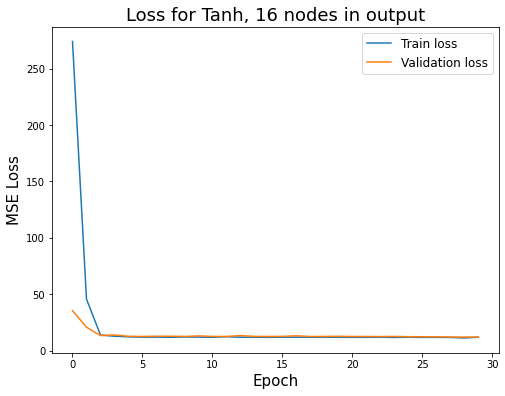

In [92]:
epochs = [i for i in range(len(info_regression.history['accuracy']))]
plt.figure(figsize=(8,6))
plt.plot(epochs, info_regression.history['loss'], label="Train loss")
plt.plot(epochs, info_regression.history['val_loss'], label="Validation loss")
plt.legend(fontsize=12)
plt.xlabel("Epoch", fontsize=15)
plt.ylabel("MSE Loss", fontsize=15)
plt.title("Loss for Tanh, 16 nodes in output", fontsize=18)
#plt.savefig('drive/MyDrive/data/results/Softmax_categorical')

In [93]:
regression_model.load_weights(filepath = 'drive/MyDrive/data/results/.regression_best_weights.hdf5')

In [94]:
# now calculate the actual accuracy
test_predictions = regression_model.predict(X_test)
train_predictions = regression_model.predict(X_train)
val_predictions = regression_model.predict(X_val)

In [95]:
final_pred = enc.inverse_transform(test_predictions).squeeze()
final_train_pred = enc.inverse_transform(train_predictions).squeeze()
final_val_pred = enc.inverse_transform(val_predictions).squeeze()

ValueError: ignored

In [96]:
test_acc = accuracy(final_pred, y_test)
train_acc = accuracy(final_train_pred, y_train)
val_acc = accuracy(final_val_pred, y_val)
print("Classification with tanh")
print("----Results----")
print(f"Size of train set: {y_train.shape[0]}")
print(f"Train acc: {train_acc}")
print(f"----\nSize of validation set: {y_val.shape[0]}")
print(f"Validation acc: {val_acc}")
print(f"----\nSize of test set: {y_test.shape[0]}")
print(f"Test acc: {test_acc}")

Classification with tanh
----Results----
Size of train set: 185
Train acc: 0.1891891891891892
----
Size of validation set: 53
Validation acc: 0.1509433962264151
----
Size of test set: 33
Test acc: 0.2727272727272727


In [100]:
y_train

array([ 0.,  2.,  6.,  4.,  7.,  7.,  5., 11., 12.,  1.,  0.,  0.,  3.,
        0.,  5.,  1.,  0.,  0.,  1.,  3.,  2.,  2.,  2.,  0.,  2.,  6.,
        2.,  0.,  1.,  9.,  0.,  9.,  8.,  0.,  0.,  2.,  0.,  0.,  5.,
        0.,  3.,  6.,  3.,  7.,  1.,  1.,  4.,  3.,  3.,  0.,  4., 10.,
        3.,  1.,  1.,  3.,  0.,  5.,  5.,  3.,  5.,  2.,  2.,  1., 12.,
        1.,  1.,  2.,  0.,  3., 12.,  0.,  1.,  2.,  3.,  0.,  1.,  1.,
       12.,  2.,  5.,  0.,  2.,  6.,  7., 10.,  7.,  4.,  2.,  6.,  3.,
        2.,  7.,  6.,  9.,  1.,  2.,  0.,  1.,  8.,  3., 14.,  1.,  1.,
        6.,  6.,  0.,  5.,  1.,  5.,  1., 10.,  0.,  8.,  2.,  1.,  0.,
        1.,  1.,  5.,  9.,  6.,  1.,  1.,  4.,  1.,  0.,  1.,  5.,  3.,
        0.,  2.,  6.,  6., 11.,  5.,  3.,  2.,  8.,  5., 13.,  8.,  1.,
        3.,  0.,  9.,  0., 11.,  2.,  4.,  1., 10.,  0.,  3.,  9.,  0.,
        2.,  0., 11.,  1.,  0.,  4.,  2.,  4.,  2.,  1., 15.,  0.,  6.,
        6.,  0.,  5.,  2.,  4.,  6.,  1.,  2.,  2.,  1.,  3.,  2